<a href="https://colab.research.google.com/github/khemsu/LangGraph_tut/blob/main/Node_%26_Their_relationship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install langgraph


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 22.7 MB/s eta 0:00:00


In [16]:
from typing import TypedDict, Dict, List, Any
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
import pprint

In [17]:
class GraphState(TypedDict, total=False):
    student: Dict[str, Any]
    college: Dict[str, Any]
    skill: Dict[str, Any]

    students: Dict[str, Dict[str, Any]]
    colleges: Dict[str, Dict[str, Any]]
    skills: Dict[str, Dict[str, Any]]

    student_college: Dict[str, str]
    student_skills: Dict[str, List[str]]
    skill_sources: Dict[str, Dict[str, Any]]


In [18]:
graph_builder = StateGraph(GraphState)

In [19]:
def student_node(state: GraphState) -> GraphState:
    student = state.get("student")
    student_id = student["roll"]

    state["students"] = state.get("students", {})
    state["students"][student_id] = {
        "name": student["name"],
        "roll": student["roll"],
        "phone": student["phone"],
        "address": student["address"],
        "faculty": student["faculty"],
        "year": student["year"],
        "result": student["result"]
    }
    return state

def college_node(state: GraphState) -> GraphState:
    college = state.get("college")
    student_id = state["student"]["roll"]
    college_id = college["name"]

    state["colleges"] = state.get("colleges", {})
    state["colleges"][college_id] = {
        "name": college["name"],
        "address": college["address"],
        "faculty": college["faculty"],
        "department": college["department"]
    }
    #creating student_college for maintaining student and college relation
    state["student_college"] = state.get("student_college", {})

    #for mapping student to their respective college by college name
    state["student_college"][student_id] = college_id
    return state

def skill_node(state: GraphState) -> GraphState:
    skill = state.get("skill")
    student_id = state["student"]["roll"]
    college_id = state["student_college"][student_id] #for college_id Student studied in which college is given by student_college from above node
    department = state["college"]["department"]

    skill_id = f"{student_id}_{skill['name']}"
    state["skills"] = state.get("skills", {})
    state["skills"][skill_id] = {
        "name": skill["name"],
        "experience_years": skill["experience_years"]
    }

    #for student skill it looks to student_id
    state["student_skills"] = state.get("student_skills", {})
    state["student_skills"].setdefault(student_id, []).append(skill_id)

    #for skill sources which coolege and department
    state["skill_sources"] = state.get("skill_sources", {})
    state["skill_sources"][skill_id] = {
        "college_id": college_id,
        "department": department
    }

    return state

Add nodes to graph

In [20]:
graph_builder.add_node("student_node", student_node)
graph_builder.add_node("college_node", college_node)
graph_builder.add_node("skill_node", skill_node)

now adding edges

In [21]:
graph_builder.add_edge(START, "student_node")
graph_builder.add_edge("student_node", "college_node")
graph_builder.add_edge("college_node", "skill_node")
graph_builder.add_edge("skill_node", END)


In [22]:
graph = graph_builder.compile()

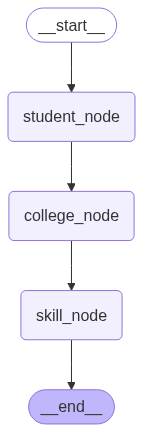

In [23]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [24]:
initial_state: GraphState = {
    "student": {
        "name": "Khemsu",
        "roll": "CS001",
        "phone": "9814338831",
        "address": "Lalitpur",
        "faculty": "Science",
        "year": 2,
        "result": "3.7 GPA"
    },
    "college": {
        "name": "Achs",
        "address": "Lalitpur",
        "faculty": "Science",
        "department": "Computer Science"
    },
    "skill": {
        "name": "Python",
        "experience_years": 1.5
    }
}

final_state = graph.invoke(initial_state)

print("\n Final State:")

pprint.pprint(final_state)


 Final State:
{'college': {'address': 'Lalitpur',
             'department': 'Computer Science',
             'faculty': 'Science',
             'name': 'Achs'},
 'colleges': {'Achs': {'address': 'Lalitpur',
                       'department': 'Computer Science',
                       'faculty': 'Science',
                       'name': 'Achs'}},
 'skill': {'experience_years': 1.5, 'name': 'Python'},
 'skill_sources': {'CS001_Python': {'college_id': 'Achs',
                                    'department': 'Computer Science'}},
 'skills': {'CS001_Python': {'experience_years': 1.5, 'name': 'Python'}},
 'student': {'address': 'Lalitpur',
             'faculty': 'Science',
             'name': 'Khemsu',
             'phone': '9814338831',
             'result': '3.7 GPA',
             'roll': 'CS001',
             'year': 2},
 'student_college': {'CS001': 'Achs'},
 'student_skills': {'CS001': ['CS001_Python']},
 'students': {'CS001': {'address': 'Lalitpur',
                        'fac